## ICP
The Iterative Closest Point algorithm (ICP) is a widely used method in computer vision and robotics for aligning two sets of points in 2D or 3D space.

If you are on Colab, it is possible that google doesn't have Open3D preinstalled. Install it using the following command.

Open3D is an open-source library designed for processing and visualizing 3D data.

In [2]:
# !pip install open3d

In [3]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy

# IO and Preprocessing

## Input Camera Intrinsics

In [4]:
w, h, fx, fy, cx, cy, sf = 640, 480, 535.4, 539.2, 320.1, 247.6, 5000
K = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy)

In [5]:
K

PinholeCameraIntrinsic with width = 640 and height = 480.
Access intrinsics with intrinsic_matrix.

## Load Color and Depth Images

The images are from the sequence 'freiburg3_long_office_household' of the TUM RGB-D SLAM Dataset and Benchmark:
https://vision.in.tum.de/data/datasets/rgbd-dataset

In [6]:
rgb_1 = o3d.io.read_image("./images/rgb_1.png")
dep_1 = o3d.io.read_image("./images/dep_1.png")
rgb_2 = o3d.io.read_image("./images/rgb_2.png")
dep_2 = o3d.io.read_image("./images/dep_2.png")
print(rgb_1)

Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


In [7]:
temp = o3d.io.read_image("./images/dep_7.png")
print(temp)

[Open3D WARNING] Read PNG failed: unable to parse header.
Image of size 0x0, with 0 channels.
Use numpy.asarray to access buffer data.


Similar to OpenCV, Open3D won't raise an error when the reading fails. Even worse, you are not getting a None object either like in OpenCV. Instead you will have a valid Image object, but with 0 pixel. So always remember print the image to see its size

## Creating RGBD Image From RGB and D Images

In [8]:
rgbd_1 = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_1, dep_1, depth_scale=sf, convert_rgb_to_intensity=False)
rgbd_2 = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_2, dep_2, depth_scale=sf, convert_rgb_to_intensity=False)
print(rgbd_1)
print(rgbd_2)

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.
RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


# Visualize Color and Depth Images

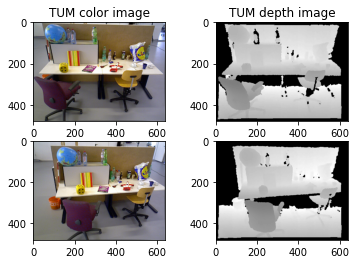

In [9]:
plt.subplot(2, 2, 1)
plt.title('TUM color image')
plt.imshow(rgbd_1.color)
plt.subplot(2, 2, 2)
plt.title('TUM depth image')
plt.imshow(rgbd_1.depth, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(rgbd_2.color)
plt.subplot(2, 2, 4)
plt.imshow(rgbd_2.depth, cmap='gray')
plt.show()

## Convert RGBD Image to Point Cloud

Point Cloud is just one way to represent 3D object. Other options exist like Voxel/Volumetric Grid. There are several benefit of Point Cloud, but the one we care about in this class is its efficiency.


Imagine a dragon figurine. Because of it's highly irregular shape, if we were to represend it in a volumetric grid, we will have many coordinate that has no feature at all.

**Only run the following block if you are on a native Jupyter environment**

In [10]:
pcd_dragon = o3d.io.read_point_cloud('./Fantasy Dragon.ply')

o3d.visualization.draw_geometries([pcd_dragon],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])


Open3D provides a convenient way for us to turn a RGBD image into a point cloud

In [11]:
pcd_1 = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_1, K)
pcd_2 = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_2, K)
pcd_unregistered = pcd_1 + pcd_2
o3d.io.write_point_cloud('pcd_unregistered.ply', pcd_unregistered)

True

# Local ICP

## Point-to-Point ICP

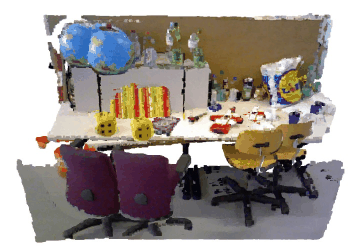

In [12]:
reg = o3d.pipelines.registration.registration_icp(pcd_2, pcd_1, 0.1)
pcd_2_t = copy.deepcopy(pcd_2)
pcd_2_t.transform(reg.transformation)
pcd_registered = pcd_1 + pcd_2_t
o3d.io.write_point_cloud('pcd_point_to_point.ply', pcd_registered)

True

In [13]:
o3d.visualization.draw_geometries([pcd_registered],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])




## Point-to-Plane ICP
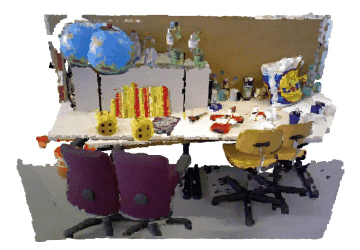

The basic difference between Point-to-Point ICP and Point-to-Plane ICP is how they compute error between corresponding points to the update the transformation during the alignment process. Point-to-Point ICP uses Euclidean distance between corresponding points as the error metric. While Point-to-Plane ICP uses distance between points and the corresponding planes fitted to the target points. It tries to minimize the sum of squared distances between points and their corresponding planes.

In [14]:
pcd_1.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=5))
pcd_2.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=5))
reg = o3d.pipelines.registration.registration_icp(pcd_2, pcd_1, 0.1, estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane())
pcd_2_t = copy.deepcopy(pcd_2)
pcd_2_t.transform(reg.transformation)
pcd_registered = pcd_1 + pcd_2_t
o3d.io.write_point_cloud('pcd_point_to_plane.ply', pcd_registered)

True

In [15]:
o3d.visualization.draw_geometries([pcd_registered],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

As we can see, Point-to-Plane ICP already achieved almost perfect results. But can we do this even faster?

## Colored-ICP

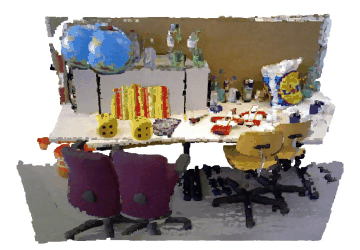

In [16]:
reg = o3d.pipelines.registration.registration_colored_icp(pcd_2, pcd_1, 0.1)
pcd_2_t = copy.deepcopy(pcd_2)
pcd_2_t.transform(reg.transformation)
pcd_registered = pcd_1 + pcd_2_t
o3d.io.write_point_cloud('pcd_colored.ply', pcd_registered)

True

In [17]:
o3d.visualization.draw_geometries([pcd_registered],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

With color ICP, because we take advantage of the color information, we can achieve the same results as Point-to-Plane ICP, but with faster speed

## RMSE curve
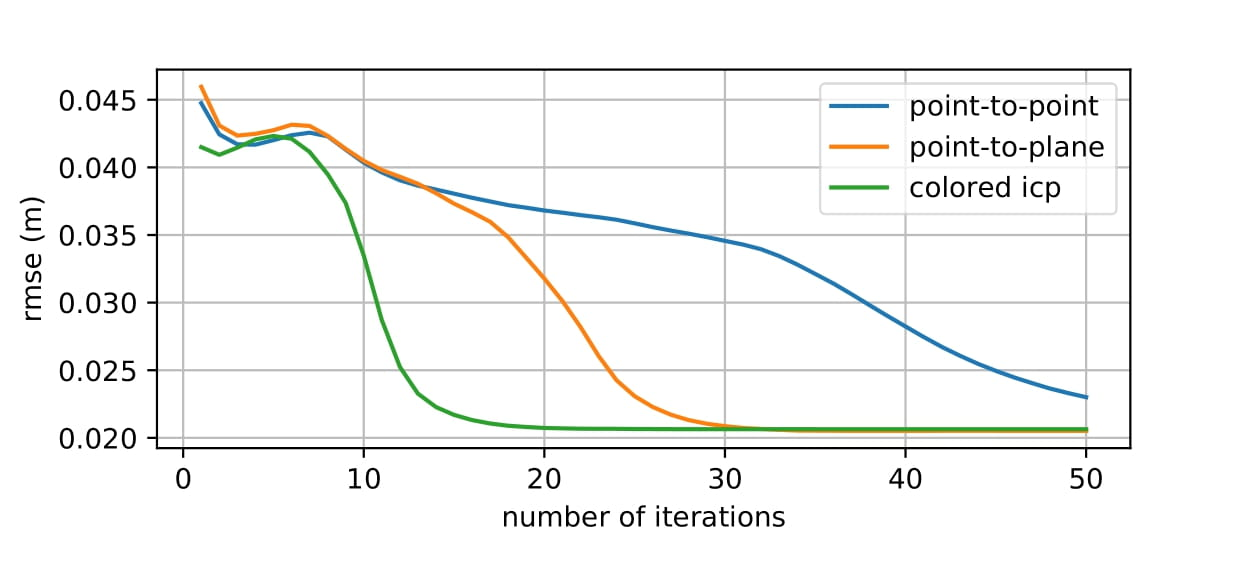

# Global Registration

How do we tackle a problem where we want to register multiple point clouds?

## Combine two local registration

A naive way to solve this is, we can iterative apply ICP on three point clouds

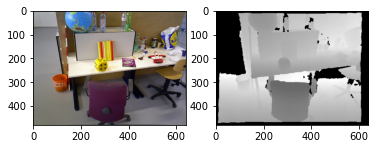

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


In [18]:
# read the third rgbd images and get the point cloud
rgb_3 = o3d.io.read_image("./images/rgb_3.png")
dep_3 = o3d.io.read_image("./images/dep_3.png")
rgbd_3 = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_3, dep_3, depth_scale=sf, convert_rgb_to_intensity=False)
pcd_3 = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_3, K)
plt.subplot(1, 2, 1)
plt.imshow(rgbd_3.color)
plt.subplot(1, 2, 2)
plt.imshow(rgbd_3.depth, cmap='gray')
plt.show()
print(rgbd_3)

In [19]:
# First align pcd_2 to pcd_1 then align pcd_3 to pcd_2
# align pcd_2 to pcd_1
reg21 = o3d.pipelines.registration.registration_icp(pcd_2, pcd_1, 0.1,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane())
pcd_2_t = copy.deepcopy(pcd_2)
pcd_2_t.transform(reg21.transformation)

# align pcd_3 to pcd_2
pcd_3.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=5))
reg32 = o3d.pipelines.registration.registration_icp(pcd_3, pcd_2, 0.1,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        criteria=o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=200))
pcd_3_t = copy.deepcopy(pcd_3)
pcd_3_t.transform(reg32.transformation)
pcd_3_t.transform(reg21.transformation)
pcd_registered = pcd_1 + pcd_2_t + pcd_3_t
o3d.io.write_point_cloud('pcd_relative_local.ply', pcd_registered)

True

In [20]:
o3d.visualization.draw_geometries([pcd_registered],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

## Global registration

However, just like in SLAM/SfM, these iterative methods tend to accumulate error. Global method is usually better. Below is an example of a map constructed during SLAM, where the left is we iteratively connect scans and the right is we do a global optimization.
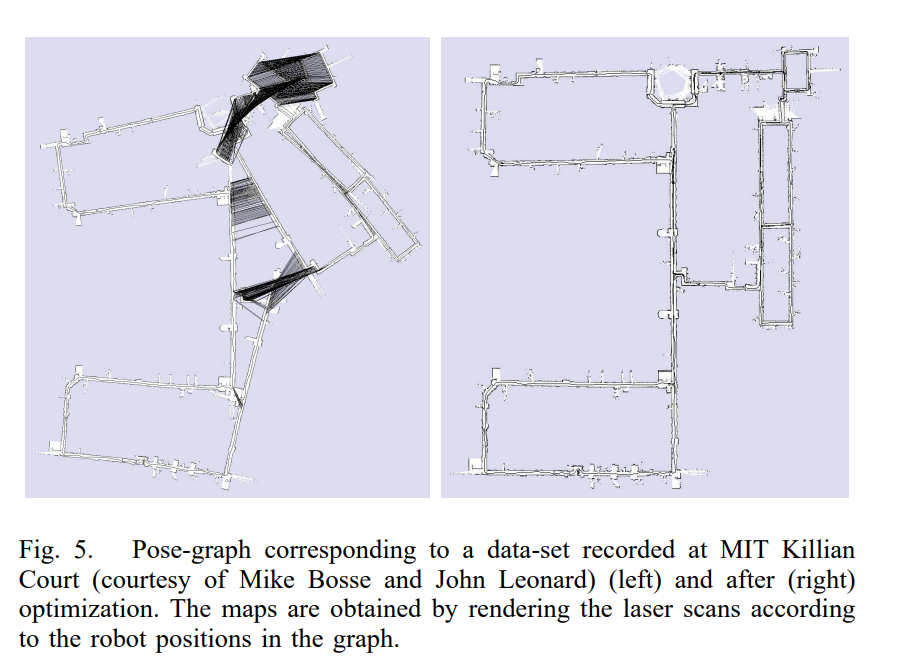

Usually, we adopt a so-called graph-based method. We treat each point cloud as a node, and the relative pose between them as edge between the two nodes.

### Construct nodes and edges

In [21]:
# The nodes are the poses for the RGBD images
node_1 = o3d.pipelines.registration.PoseGraphNode(np.eye(4))
node_2 = o3d.pipelines.registration.PoseGraphNode(reg21.transformation)
node_3 = o3d.pipelines.registration.PoseGraphNode(reg21.transformation @ reg32.transformation)
print(node_1.pose, node_2.pose, node_3.pose)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] [[ 0.99042437 -0.0631283   0.12277776 -0.56953564]
 [ 0.06699554  0.99737078 -0.0276247   0.02598557]
 [-0.12071105  0.03558574  0.99204964 -0.04053531]
 [ 0.          0.          0.          1.        ]] [[ 0.96842851 -0.13075272  0.21224972 -0.97170435]
 [ 0.12902387  0.99139659  0.02203728 -0.05832951]
 [-0.21330509  0.00604375  0.97696695  0.29959504]
 [ 0.          0.          0.          1.        ]]


In [22]:
# initilialize the relative pose between pcd_1 and pcd_3
reg13 = o3d.pipelines.registration.registration_icp(pcd_1, pcd_3, 0.1,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        criteria=o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=200))

In [23]:
# The edges are the relative constraints between nodes
edge_21 = o3d.pipelines.registration.PoseGraphEdge(1, 0, reg21.transformation)
edge_32 = o3d.pipelines.registration.PoseGraphEdge(2, 1, reg32.transformation)
edge_13 = o3d.pipelines.registration.PoseGraphEdge(0, 2, reg13.transformation)

In [24]:
# construct pose graph
pose_graph = o3d.pipelines.registration.PoseGraph()
pose_graph.nodes.append(node_1)
pose_graph.nodes.append(node_2)
pose_graph.nodes.append(node_3)
pose_graph.edges.append(edge_21)
pose_graph.edges.append(edge_32)
pose_graph.edges.append(edge_13)


### Optimization

Under the hood this is doing Bundle Adjustment

In [25]:
# optimize
criteria = o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria()
option = o3d.pipelines.registration.GlobalOptimizationOption(
        max_correspondence_distance=0.05,
        edge_prune_threshold=0.25,
        reference_node=0)

o3d.pipelines.registration.global_optimization(pose_graph,
            o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
            criteria,
            option)



In [26]:
pose_1_o = pose_graph.nodes[0].pose
pose_2_o = pose_graph.nodes[1].pose
pose_3_o = pose_graph.nodes[2].pose
print(pose_1_o, pose_2_o, pose_3_o)
pcd_registered = pcd_1 + copy.deepcopy(pcd_2).transform(pose_2_o) + copy.deepcopy(pcd_3).transform(pose_3_o)
o3d.io.write_point_cloud('pcd_global.ply', pcd_registered)

[[ 1.00000000e+00  2.50721752e-19  0.00000000e+00  0.00000000e+00]
 [-1.89735380e-19  1.00000000e+00  0.00000000e+00 -1.73472348e-18]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 0.99019254 -0.06066694  0.12585011 -0.57816405]
 [ 0.06431123  0.99761429 -0.02509566  0.0162975 ]
 [-0.1240274   0.03294311  0.9917318  -0.04161827]
 [ 0.          0.          0.          1.        ]] [[ 0.96728841 -0.12290094  0.22191999 -0.98808045]
 [ 0.11939644  0.99241742  0.0291918  -0.07578813]
 [-0.22382496 -0.00174043  0.9746278   0.29893562]
 [ 0.          0.          0.          1.        ]]


True

In [27]:
o3d.visualization.draw_geometries([pcd_registered],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

# Homework


Perform point-to-point, point-to-plane and colored ICP
using rgb_4, rgb_5, dep_4 and dep_5.

Visualize the unregistered point cloud and the
registered point clouds from the above three methods using Open3D.

Upload the screenshots of the visualizations to [HW6 Google Form](https://forms.gle/GfV2SkDWYJdcqK7B8).